In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

In [4]:
def compute_nb_errors(model, data_input, data_target, batch_size):
    nb_errors = 0
    Ndata = len(data_input[:, 0, 0, 0])
    model.eval()
    print('data_target', data_target.shape)
    print('data_input', data_input.shape)
    
    for b_start in range(0, Ndata, batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
seeds = list(range(50))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs) #from PdM
    #model = conv2DNet_6(Noutputs)
    
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  66.56666666666666
	 Validation accuracy  55.0
	 Test accuracy  46.8
	 Epoch Loss  132.39337158203125
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  75.93333333333334
	 Validation accuracy  58.75
	 Test accuracy  50.3
	 Epoch Loss  107.22852325439453
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  83.43333333333334
	 Va

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  23
	 Training accuracy:  92.63333333333334
	 Validation accuracy  52.5
	 Test accuracy  53.1
	 Epoch Loss  0.1979069858789444
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  92.7
	 Validation accuracy  51.875
	 Test accuracy  52.9
	 Epoch Loss  0.16938024759292603
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  92.6
	 Validation accuracy  51.25
	 Test accuracy  52.5
	 Epoch Loss  0.14564937353134155
data_target torch.Size([3

Epoch Number :  46
	 Training accuracy:  93.0
	 Validation accuracy  50.0
	 Test accuracy  51.9
	 Epoch Loss  0.00984170287847519
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  92.96666666666667
	 Validation accuracy  50.0
	 Test accuracy  51.8
	 Epoch Loss  0.008752860128879547
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  93.03333333333333
	 Validation accuracy  50.0
	 Test accuracy  51.4
	 Epoch Loss  0.0077988868579268456
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  96.46666666666667
	 Validation accuracy  41.25
	 Test accuracy  64.9
	 Epoch Loss  0.06354165822267532
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  96.33333333333333
	 Validation accuracy  43.125
	 Test accuracy  65.0
	 Epoch Loss  0.054829809814691544
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  96.4
	 Validation accuracy 

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  96.5
	 Validation accuracy  45.625
	 Test accuracy  64.7
	 Epoch Loss  0.0032207851763814688
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  96.5
	 Validation accuracy  45.625
	 Test accuracy  64.8
	 Epoch Loss  0.002850487595424056
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  96.6
	 Validation accuracy  45.625
	 Test accuracy  64.7
	 Epoch Loss  0.0025280064437538385
data_target torch.Size([3000]

Epoch Number :  16
	 Training accuracy:  92.16666666666667
	 Validation accuracy  43.125
	 Test accuracy  52.3
	 Epoch Loss  0.26716652512550354
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  17
	 Training accuracy:  92.2
	 Validation accuracy  42.5
	 Test accuracy  52.8
	 Epoch Loss  0.22628533840179443
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  92.4
	 Validation accuracy  42.5
	 Test accuracy  52.9
	 Epoch Loss  0.18986622989177704
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  92.4
	 Validation accuracy  42.5
	 Test accuracy  54.8
	 Epoch Loss  0.010628347285091877
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  92.23333333333333
	 Validation accuracy  41.875
	 Test accuracy  54.7
	 Epoch Loss  0.009455257095396519
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  92.26666666666667
	 Validation accuracy 

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  97.6
	 Validation accuracy  56.25
	 Test accuracy  64.9
	 Epoch Loss  0.21459071338176727
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  97.53333333333333
	 Validation accuracy  56.25
	 Test accuracy  64.9
	 Epoch Loss  0.17349044978618622
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  97.6
	 Validation accuracy  56.25
	 Test accuracy  65.1
	 Epoch Loss  0.14377814531326294
data_target torch.Size([

Epoch Number :  36
	 Training accuracy:  97.36666666666666
	 Validation accuracy  55.0
	 Test accuracy  65.0
	 Epoch Loss  0.008475063368678093
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  97.36666666666666
	 Validation accuracy  54.375
	 Test accuracy  65.0
	 Epoch Loss  0.007590930908918381
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  97.4
	 Validation accuracy  54.375
	 Test accuracy  65.0
	 Epoch Loss  0.006788615602999926
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_ta

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  93.43333333333334
	 Validation accuracy  50.0
	 Test accuracy  59.2
	 Epoch Loss  0.6161706447601318
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  93.5
	 Validation accuracy  51.25
	 Test accuracy  59.0
	 Epoch Loss  0.4817771017551422
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  93.76666666666667
	 Validation accuracy  51.8

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  94.43333333333334
	 Validation accuracy  56.25
	 Test accuracy  60.9
	 Epoch Loss  0.016750801354646683
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  94.36666666666666
	 Validation accuracy  56.25
	 Test accuracy  61.4
	 Epoch Loss  0.014779038727283478
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  94.43333333333334
	 Validation accuracy  56.25
	 Test accuracy  61.2
	 Epoch Loss  0.01293671224266

Epoch Number :  6
	 Training accuracy:  95.0
	 Validation accuracy  56.25
	 Test accuracy  59.1
	 Epoch Loss  7.641070365905762
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  93.63333333333334
	 Validation accuracy  55.625
	 Test accuracy  66.3
	 Epoch Loss  10.439594268798828
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  94.96666666666667
	 Validation accuracy  60.625
	 Test accuracy  61.0
	 Epoch Loss  10.800557136535645
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torc

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  97.6
	 Validation accuracy  58.75
	 Test accuracy  60.4
	 Epoch Loss  0.036141619086265564
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  31
	 Training accuracy:  97.5
	 Validation accuracy  58.75
	 Test accuracy  60.2
	 Epoch Loss  0.03166746348142624
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  97.5
	 Validation accuracy  58.75
	 Test accuracy  60.

Epoch Number :  3
	 Training accuracy:  94.76666666666667
	 Validation accuracy  46.875
	 Test accuracy  64.8
	 Epoch Loss  21.76654815673828
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  94.53333333333333
	 Validation accuracy  40.625
	 Test accuracy  66.1
	 Epoch Loss  10.120625495910645
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  93.43333333333334
	 Validation accuracy  41.25
	 Test accuracy  65.6
	 Epoch Loss  7.216545581817627
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  98.13333333333334
	 Validation accuracy  45.0
	 Test accuracy  69.6
	 Epoch Loss  0.03212888166308403
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  98.16666666666667
	 Validation accuracy  45.0
	 Test accuracy  69.2
	 Epoch Loss  0.028416158631443977
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  98.23333333333333
	 Validation

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  72.56666666666666
	 Validation accuracy  55.0
	 Test accuracy  60.2
	 Epoch Loss  125.00369262695312
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  81.46666666666667
	 Validation accuracy  68.75
	 Test accuracy  59.0
	 Epoch Loss  82.66525268554688
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  90.53333333333333
	 Validation accuracy  61.25
	 Test accuracy  56.9
	 Epoch Loss  39.9288444519043
data_tar

Epoch Number :  23
	 Training accuracy:  96.4
	 Validation accuracy  65.0
	 Test accuracy  63.4
	 Epoch Loss  0.06786437332630157
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  96.5
	 Validation accuracy  64.375
	 Test accuracy  63.4
	 Epoch Loss  0.05926103517413139
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  96.43333333333334
	 Validation accuracy  63.75
	 Test accuracy  63.6
	 Epoch Loss  0.05197766795754433
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  96.1
	 Validation accuracy  65.0
	 Test accuracy  64.1
	 Epoch Loss  0.003772583557292819
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  96.2
	 Validation accuracy  65.0
	 Test accuracy  63.8
	 Epoch Loss  0.00333039159886539
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  96.16666666666667
	 Validation accuracy  65.0
	 Test acc

data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  95.16666666666667
	 Validation accuracy  53.75
	 Test accuracy  71.0
	 Epoch Loss  0.09125674515962601
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  95.3
	 Validation accuracy  53.75
	 Test accuracy  70.7
	 Epoch Loss  0.0786370187997818
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  95.3
	 Validation accuracy  54.375
	 Test accuracy  70.8
	 Epoch Loss  0.06769474595785141
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size

Epoch Number :  43
	 Training accuracy:  95.66666666666667
	 Validation accuracy  53.75
	 Test accuracy  71.4
	 Epoch Loss  0.004731382243335247
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  95.7
	 Validation accuracy  53.75
	 Test accuracy  71.3
	 Epoch Loss  0.004243392497301102
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  95.66666666666667
	 Validation accuracy  53.75
	 Test accuracy  71.3
	 Epoch Loss  0.0037681206595152617
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_ta

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  17
	 Training accuracy:  98.16666666666667
	 Validation accuracy  70.625
	 Test accuracy  69.6
	 Epoch Loss  0.08876044303178787
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  98.16666666666667
	 Validation accuracy  70.625
	 Test accuracy  69.5
	 Epoch Loss  0.07555104047060013
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  98.23333333333333
	 Validat

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  98.5
	 Validation accuracy  72.5
	 Test accuracy  69.4
	 Epoch Loss  0.004431118723005056
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  98.5
	 Validation accuracy  73.125
	 Test accuracy  69.5
	 Epoch Loss  0.003948205150663853
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  98.53333333333333
	 Validation accuracy  71.875
	 Test accuracy  69.6
	 Epoch Loss  0.0035243865568190813
data_target torch.S

Epoch Number :  13
	 Training accuracy:  98.73333333333333
	 Validation accuracy  54.375
	 Test accuracy  69.0
	 Epoch Loss  0.19952449202537537
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  98.66666666666667
	 Validation accuracy  53.125
	 Test accuracy  69.0
	 Epoch Loss  0.16367225348949432
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  98.66666666666667
	 Validation accuracy  53.125
	 Test accuracy  69.2
	 Epoch Loss  0.13655410706996918
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  98.63333333333334
	 Validation accuracy  65.625
	 Test accuracy  69.0
	 Epoch Loss  0.007061902433633804
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  98.63333333333334
	 Validation accuracy  66.25
	 Test accuracy  69.1
	 Epoch Loss  0.0062752095982432365
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  98.63333333333334
	 Valid

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  97.36666666666666
	 Validation accuracy  76.875
	 Test accuracy  64.8
	 Epoch Loss  0.419648140668869
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  97.26666666666667
	 Validation accuracy  76.875
	 Test accuracy  64.8
	 Epoch Loss  0.3302740454673767
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  97.4
	 Validation accuracy  76

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  97.43333333333334
	 Validation accuracy  76.25
	 Test accuracy  64.7
	 Epoch Loss  0.011901197955012321
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  97.46666666666667
	 Validation accuracy  76.875
	 Test accuracy  65.0
	 Epoch Loss  0.010517016984522343
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  97.5
	 Validation accuracy  76.875
	 Test accuracy  65.0
	 Epoch Loss  0.009384180419147015
data_t

Epoch Number :  6
	 Training accuracy:  95.1
	 Validation accuracy  66.25
	 Test accuracy  63.4
	 Epoch Loss  8.995734214782715
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  95.46666666666667
	 Validation accuracy  72.5
	 Test accuracy  64.1
	 Epoch Loss  2.2532029151916504
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  95.66666666666667
	 Validation accuracy  68.75
	 Test accuracy  64.7
	 Epoch Loss  0.9436004757881165
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.S

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  95.46666666666667
	 Validation accuracy  68.75
	 Test accuracy  64.5
	 Epoch Loss  0.015647197142243385
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  31
	 Training accuracy:  95.43333333333334
	 Validation accuracy  69.375
	 Test accuracy  64.6
	 Epoch Loss  0.013805398717522621
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  95.46666666666667
	 Valida

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  97.2
	 Validation accuracy  69.375
	 Test accuracy  63.6
	 Epoch Loss  19.614715576171875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  96.0
	 Validation accuracy  70.625
	 Test accuracy  62.6
	 Epoch Loss  10.358416557312012
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  97.73333333333333
	 Validation accuracy  70.0
	 Test accur

Epoch Number :  26
	 Training accuracy:  98.6
	 Validation accuracy  63.125
	 Test accuracy  64.1
	 Epoch Loss  0.041293878108263016
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  98.6
	 Validation accuracy  63.125
	 Test accuracy  64.0
	 Epoch Loss  0.036437444388866425
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  98.63333333333334
	 Validation accuracy  63.75
	 Test accuracy  63.4
	 Epoch Loss  0.032337091863155365
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.S

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  73.3
	 Validation accuracy  56.25
	 Test accuracy  50.5
	 Epoch Loss  123.45447540283203
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  83.93333333333334
	 Validation accuracy  65.0
	 Test accuracy  59.4
	 Epoch Loss  87.13751220703125
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  89.9
	 Validation accuracy  62.5
	 Test accuracy 

Epoch Number :  23
	 Training accuracy:  96.03333333333333
	 Validation accuracy  68.75
	 Test accuracy  60.2
	 Epoch Loss  0.05940195545554161
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  96.06666666666666
	 Validation accuracy  67.5
	 Test accuracy  60.3
	 Epoch Loss  0.05172124132514
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  96.03333333333333
	 Validation accuracy  67.5
	 Test accuracy  60.4
	 Epoch Loss  0.04511994868516922
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
dat

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  95.73333333333333
	 Validation accuracy  63.75
	 Test accuracy  59.9
	 Epoch Loss  0.003105520736426115
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  95.73333333333333
	 Validation accuracy  63.75
	 Test accuracy  59.9
	 Epoch Loss  0.0027843813877552748
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  95.7
	 Validation accuracy

Epoch Number :  20
	 Training accuracy:  93.26666666666667
	 Validation accuracy  57.5
	 Test accuracy  63.7
	 Epoch Loss  0.13138476014137268
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  93.33333333333333
	 Validation accuracy  56.875
	 Test accuracy  63.5
	 Epoch Loss  0.11464076489210129
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  93.36666666666666
	 Validation accuracy  56.875
	 Test accuracy  63.7
	 Epoch Loss  0.09938959777355194
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  93.86666666666666
	 Validation accuracy  56.25
	 Test accuracy  62.9
	 Epoch Loss  0.0067969076335430145
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  93.93333333333334
	 Validation accuracy  56.25
	 Test accuracy  62.8
	 Epoch Loss  0.006060853134840727
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  94.03333333333333
	 Valida

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  17
	 Training accuracy:  92.56666666666666
	 Validation accuracy  48.125
	 Test accuracy  54.5
	 Epoch Loss  0.23553232848644257
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  92.63333333333334
	 Validation accuracy  46.25
	 Test accuracy  54.5
	 Epoch Loss  0.19768722355365753
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  92.73333333333333
	 Validation accuracy  46.875
	 Test accuracy  54.6
	 Epoch Loss  0.16717018187046

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  94.0
	 Validation accuracy  49.375
	 Test accuracy  57.6
	 Epoch Loss  0.13720566034317017
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  94.03333333333333
	 Validation accuracy  49.375
	 Test accuracy  57.6
	 Epoch Loss  0.13382549583911896
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  93.96666666666667
	 Validation accuracy  49.375
	 Test accuracy  57.6
	 Epoch Loss  0.13026519119739532
data_tar

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  94.43333333333334
	 Validation accuracy  41.875
	 Test accuracy  47.4
	 Epoch Loss  0.3559097647666931
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  94.43333333333334
	 Validation accuracy  42.5
	 Test accuracy  47.2
	 Epoch Loss  0.2952343225479126
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  94.53333333333333
	 Validation accuracy  43.125
	 Test accuracy  47.0
	 Epoch Loss  0.25048404932022095

Epoch Number :  36
	 Training accuracy:  94.83333333333333
	 Validation accuracy  45.625
	 Test accuracy  48.8
	 Epoch Loss  0.01438941527158022
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  94.93333333333334
	 Validation accuracy  45.625
	 Test accuracy  48.6
	 Epoch Loss  0.012706469744443893
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  94.93333333333334
	 Validation accuracy  45.625
	 Test accuracy  48.7
	 Epoch Loss  0.01134027075022459
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28,

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  95.9
	 Validation accuracy  49.375
	 Test accuracy  58.7
	 Epoch Loss  0.7273773550987244
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  96.06666666666666
	 Validation accuracy  49.375
	 Test accuracy  58.8
	 Epoch Loss  0.5492307543754578
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  96.16666666666667
	 Validation accuracy  4

Epoch Number :  33
	 Training accuracy:  96.23333333333333
	 Validation accuracy  53.75
	 Test accuracy  60.5
	 Epoch Loss  0.018433842808008194
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  96.2
	 Validation accuracy  54.375
	 Test accuracy  60.4
	 Epoch Loss  0.016209719702601433
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  96.23333333333333
	 Validation accuracy  54.375
	 Test accuracy  60.4
	 Epoch Loss  0.0143662104383111
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_tar

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  97.1
	 Validation accuracy  76.875
	 Test accuracy  61.9
	 Epoch Loss  0.9383479356765747
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  97.2
	 Validation accuracy  76.875
	 Test accuracy  62.1
	 Epoch Loss  0.6292710304260254
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  97.16666666666667
	 Validation accuracy  76.875
	 Test acc

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  97.16666666666667
	 Validation accuracy  71.875
	 Test accuracy  64.1
	 Epoch Loss  0.013851059600710869
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  31
	 Training accuracy:  97.16666666666667
	 Validation accuracy  71.875
	 Test accuracy  64.1
	 Epoch Loss  0.012264171615242958
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  97.2
	 Validation accuracy  71.875
	 Test accuracy  63.9
	 Epoch Loss  0.010858594439923763
data_

Epoch Number :  3
	 Training accuracy:  95.7
	 Validation accuracy  68.75
	 Test accuracy  62.3
	 Epoch Loss  17.470691680908203
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  96.33333333333333
	 Validation accuracy  66.875
	 Test accuracy  62.1
	 Epoch Loss  6.912641525268555
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  96.7
	 Validation accuracy  66.875
	 Test accuracy  63.2
	 Epoch Loss  3.1077358722686768
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000]

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  98.23333333333333
	 Validation accuracy  68.75
	 Test accuracy  64.1
	 Epoch Loss  0.02244490198791027
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  98.23333333333333
	 Validation accuracy  68.75
	 Test accuracy  64.0
	 Epoch Loss  0.01970670558512211
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  98.03333333333333
	 Validatio

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  72.6
	 Validation accuracy  52.5
	 Test accuracy  50.9
	 Epoch Loss  123.21563720703125
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  81.53333333333333
	 Validation accuracy  63.125
	 Test accuracy  51.3
	 Epoch Loss  82.02106475830078
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  89.23333333333333
	 Validation accuracy  63.125


data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  23
	 Training accuracy:  97.63333333333334
	 Validation accuracy  75.0
	 Test accuracy  57.6
	 Epoch Loss  0.11983824521303177
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  97.7
	 Validation accuracy  75.0
	 Test accuracy  57.6
	 Epoch Loss  0.10501546412706375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  97.7
	 Validation accuracy  75.0
	 Test accuracy  57.7
	 Epoch Loss  0.09276536107063293
data_target torch.Size([300

Epoch Number :  46
	 Training accuracy:  97.76666666666667
	 Validation accuracy  76.25
	 Test accuracy  59.6
	 Epoch Loss  0.00807555578649044
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  97.8
	 Validation accuracy  76.875
	 Test accuracy  59.7
	 Epoch Loss  0.007208929397165775
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  97.8
	 Validation accuracy  76.25
	 Test accuracy  59.5
	 Epoch Loss  0.006434799171984196
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Siz

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  96.73333333333333
	 Validation accuracy  59.375
	 Test accuracy  68.3
	 Epoch Loss  0.10291238874197006
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  96.63333333333334
	 Validation accuracy  58.75
	 Test accuracy  68.3
	 Epoch Loss  0.08849440515041351
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  96.7
	 Validation accuracy  

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  96.16666666666667
	 Validation accuracy  69.375
	 Test accuracy  62.7
	 Epoch Loss  0.10057752579450607
Epoch    44: reducing learning rate of group 0 to 1.0000e-05.
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  96.16666666666667
	 Validation accuracy  69.375
	 Test accuracy  62.5
	 Epoch Loss  0.09736697375774384
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch 

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  95.76666666666667
	 Validation accuracy  62.5
	 Test accuracy  67.9
	 Epoch Loss  0.21271076798439026
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  17
	 Training accuracy:  95.76666666666667
	 Validation accuracy  63.75
	 Test accuracy  67.7
	 Epoch Loss  0.17961932718753815
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  95.7
	 Validation accuracy  63.125
	 Test accuracy  67.7
	 Epoch Loss  0.15145502984523773
data_target

Epoch Number :  39
	 Training accuracy:  95.53333333333333
	 Validation accuracy  63.125
	 Test accuracy  68.4
	 Epoch Loss  0.008934353478252888
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  95.73333333333333
	 Validation accuracy  62.5
	 Test accuracy  68.3
	 Epoch Loss  0.007866935804486275
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  95.63333333333334
	 Validation accuracy  62.5
	 Test accuracy  68.2
	 Epoch Loss  0.007037532050162554
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 5

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  97.53333333333333
	 Validation accuracy  64.375
	 Test accuracy  63.8
	 Epoch Loss  0.19952881336212158
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  97.56666666666666
	 Validation accuracy  64.375
	 Test accuracy  63.8
	 Epoch Loss  0.16492301225662231
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  97.56666666666666
	 Validat

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  97.63333333333334
	 Validation accuracy  66.875
	 Test accuracy  64.0
	 Epoch Loss  0.008623465895652771
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  97.66666666666667
	 Validation accuracy  66.875
	 Test accuracy  64.0
	 Epoch Loss  0.007701911963522434
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  97.6
	 Validation accuracy  66.875
	 Test accuracy  64.3
	 Epoch Loss  0.006836310029029846
data_

Epoch Number :  9
	 Training accuracy:  93.9
	 Validation accuracy  58.75
	 Test accuracy  57.0
	 Epoch Loss  1.401938557624817
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  94.1
	 Validation accuracy  58.125
	 Test accuracy  56.6
	 Epoch Loss  1.0536812543869019
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  94.2
	 Validation accuracy  58.125
	 Test accuracy  56.1
	 Epoch Loss  0.6694090366363525
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_inpu

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  94.8
	 Validation accuracy  55.625
	 Test accuracy  57.4
	 Epoch Loss  0.02029879204928875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  94.83333333333333
	 Validation accuracy  55.625
	 Test accuracy  57.2
	 Epoch Loss  0.018001118674874306
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  94.9
	 Validation accuracy  55.625
	 Te

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  97.16666666666667
	 Validation accuracy  55.0
	 Test accuracy  65.2
	 Epoch Loss  5.315347194671631
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  97.23333333333333
	 Validation accuracy  55.625
	 Test accuracy  65.2
	 Epoch Loss  1.540390133857727
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  97.3
	 Validation accuracy  56.25
	 Test accuracy  65.4
	 Epoch Loss  0.9773415327072144
data_target torch.S

Epoch Number :  29
	 Training accuracy:  97.9
	 Validation accuracy  56.25
	 Test accuracy  65.9
	 Epoch Loss  0.023114284500479698
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  97.86666666666666
	 Validation accuracy  56.25
	 Test accuracy  65.7
	 Epoch Loss  0.020311264321208
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  31
	 Training accuracy:  97.9
	 Validation accuracy  56.25
	 Test accuracy  65.9
	 Epoch Loss  0.01786569319665432
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  91.93333333333334
	 Validation accuracy  58.125
	 Test accuracy  51.1
	 Epoch Loss  28.0045108795166
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  93.93333333333334
	 Validation accuracy  61.25
	 Test accuracy  50.6
	 Epoch Loss  19.742786407470703
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  92.76666666666667
	 Validation accu

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  26
	 Training accuracy:  95.0
	 Validation accuracy  67.5
	 Test accuracy  50.3
	 Epoch Loss  0.06107931584119797
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  94.93333333333334
	 Validation accuracy  67.5
	 Test accuracy  50.0
	 Epoch Loss  0.053678762167692184
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  94.8
	 Validation accuracy  68.125
	 Test accuracy  50.3
	 Epoch Loss  0.04717659577727318
data_target torch.Size([

Epoch Number :  49
	 Training accuracy:  95.03333333333333
	 Validation accuracy  65.625
	 Test accuracy  51.6
	 Epoch Loss  0.0038770767860114574
Repetition 28
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  72.9
	 Validation accuracy  67.5
	 Test accuracy  57.0
	 Epoch Loss  124.89844512939453
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  81.96666666666667
	 Validation accuracy  68.75
	 Test accuracy  54.9
	 Epoch Loss  90.8927230834961
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
d

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  23
	 Training accuracy:  97.3
	 Validation accuracy  78.125
	 Test accuracy  63.9
	 Epoch Loss  0.09946844726800919
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  97.16666666666667
	 Validation accuracy  77.5
	 Test accuracy  64.0
	 Epoch Loss  0.08742045611143112
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  97.13333333333334
	 Validation accuracy  7

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  97.03333333333333
	 Validation accuracy  78.75
	 Test accuracy  65.2
	 Epoch Loss  0.006430346984416246
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  97.06666666666666
	 Validation accuracy  78.75
	 Test accuracy  65.1
	 Epoch Loss  0.005730884149670601
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  97.06666666666666
	 Validation accuracy  78.75
	 Test accuracy  65.1
	 Epoch Loss  0.00513530243188

Epoch Number :  19
	 Training accuracy:  97.8
	 Validation accuracy  53.75
	 Test accuracy  67.5
	 Epoch Loss  0.06435301154851913
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  97.86666666666666
	 Validation accuracy  53.125
	 Test accuracy  67.4
	 Epoch Loss  0.05508449301123619
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  97.96666666666667
	 Validation accuracy  53.75
	 Test accuracy  67.5
	 Epoch Loss  0.047841835767030716
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_targ

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  97.73333333333333
	 Validation accuracy  54.375
	 Test accuracy  67.4
	 Epoch Loss  0.00309941777959466
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  97.73333333333333
	 Validation accuracy  54.375
	 Test accuracy  67.4
	 Epoch Loss  0.0027851215563714504
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  97.73333333333333
	 Valid

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  98.43333333333334
	 Validation accuracy  64.375
	 Test accuracy  63.1
	 Epoch Loss  0.14601372182369232
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  17
	 Training accuracy:  98.56666666666666
	 Validation accuracy  65.0
	 Test accuracy  62.9
	 Epoch Loss  0.12138303369283676
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  98.6
	 Validation accuracy  65.0
	 Test accuracy  62.9
	 Epoch Loss  0.10318739712238312
data_target 

Epoch Number :  39
	 Training accuracy:  98.6
	 Validation accuracy  63.125
	 Test accuracy  62.7
	 Epoch Loss  0.00690544443204999
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  98.6
	 Validation accuracy  64.375
	 Test accuracy  62.6
	 Epoch Loss  0.006223492324352264
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  98.6
	 Validation accuracy  64.375
	 Test accuracy  62.6
	 Epoch Loss  0.005503508727997541
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
d

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  94.23333333333333
	 Validation accuracy  68.125
	 Test accuracy  59.7
	 Epoch Loss  0.247427299618721
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  94.33333333333333
	 Validation accuracy  68.125
	 Test accuracy  59.6
	 Epoch Loss  0.2046920210123062
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  94.36666666666666
	 Validation

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  94.83333333333333
	 Validation accuracy  67.5
	 Test accuracy  60.3
	 Epoch Loss  0.010228126309812069
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  95.0
	 Validation accuracy  67.5
	 Test accuracy  60.7
	 Epoch Loss  0.009105176664888859
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  94.96666666666667
	 Validation accuracy  68.75
	 Test accuracy  60.3
	 Epoch Loss  0.008079618215560913
data_targe

Epoch Number :  9
	 Training accuracy:  96.3
	 Validation accuracy  63.125
	 Test accuracy  60.6
	 Epoch Loss  2.250553846359253
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  96.8
	 Validation accuracy  64.375
	 Test accuracy  62.0
	 Epoch Loss  1.3941110372543335
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  97.1
	 Validation accuracy  64.375
	 Test accuracy  59.7
	 Epoch Loss  0.6242426037788391
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_inp

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  97.56666666666666
	 Validation accuracy  68.75
	 Test accuracy  60.2
	 Epoch Loss  0.017002250999212265
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  97.5
	 Validation accuracy  70.0
	 Test accuracy  60.3
	 Epoch Loss  0.015060823410749435
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  97.53333333333333
	 Validation accuracy  

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  91.9
	 Validation accuracy  48.125
	 Test accuracy  56.5
	 Epoch Loss  4.863152503967285
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  92.3
	 Validation accuracy  53.75
	 Test accuracy  56.8
	 Epoch Loss  2.6303303241729736
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  92.53333333333333
	 Validation accuracy  51.25
	 Test accuracy  56.1
	 Epoch Loss  1.208211064338684
data_target torch.Size([3000])


Epoch Number :  29
	 Training accuracy:  92.96666666666667
	 Validation accuracy  48.75
	 Test accuracy  55.8
	 Epoch Loss  0.027308283373713493
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  92.83333333333333
	 Validation accuracy  48.75
	 Test accuracy  55.9
	 Epoch Loss  0.02428574301302433
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  31
	 Training accuracy:  92.7
	 Validation accuracy  48.75
	 Test accuracy  55.8
	 Epoch Loss  0.02156640961766243
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_targe

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  91.7
	 Validation accuracy  56.875
	 Test accuracy  62.4
	 Epoch Loss  23.98396873474121
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  95.33333333333333
	 Validation accuracy  61.25
	 Test accuracy  61.9
	 Epoch Loss  13.112730026245117
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  95.86666666666666
	 Validation accuracy  55.625

Epoch Number :  26
	 Training accuracy:  97.63333333333334
	 Validation accuracy  63.75
	 Test accuracy  60.4
	 Epoch Loss  0.08880064636468887
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  97.6
	 Validation accuracy  63.75
	 Test accuracy  60.2
	 Epoch Loss  0.07743771374225616
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  97.6
	 Validation accuracy  63.75
	 Test accuracy  60.0
	 Epoch Loss  0.06781347095966339
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  76.7
	 Validation accuracy  54.375
	 Test accuracy  59.3
	 Epoch Loss  118.31021118164062
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  91.66666666666667
	 Validation accuracy  55.0
	 Test accuracy  62.3
	 Epoch Loss  61.19191360473633
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  94.53333333333333
	 Validation accuracy  54.375
	 Test accuracy  64.2
	 Epoch Loss  28.634632110595703
data_target torch

Epoch Number :  23
	 Training accuracy:  98.9
	 Validation accuracy  49.375
	 Test accuracy  68.7
	 Epoch Loss  0.04934082180261612
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  98.86666666666666
	 Validation accuracy  49.375
	 Test accuracy  68.9
	 Epoch Loss  0.04324929043650627
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  98.86666666666666
	 Validation accuracy  50.0
	 Test accuracy  68.7
	 Epoch Loss  0.03782804310321808
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_targe

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  98.2
	 Validation accuracy  68.125
	 Test accuracy  74.5
	 Epoch Loss  1.2132385969161987
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  98.46666666666667
	 Validation accuracy  69.375
	 Test accuracy  74.7
	 Epoch Loss  0.6767133474349976
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  98.66666666666667
	 Validation accuracy  6

Epoch Number :  20
	 Training accuracy:  95.9
	 Validation accuracy  55.625
	 Test accuracy  65.0
	 Epoch Loss  0.07297371327877045
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  95.96666666666667
	 Validation accuracy  55.625
	 Test accuracy  64.9
	 Epoch Loss  0.06357251852750778
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  95.96666666666667
	 Validation accuracy  55.625
	 Test accuracy  65.0
	 Epoch Loss  0.05548160523176193
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_tar

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  96.13333333333334
	 Validation accuracy  55.625
	 Test accuracy  64.6
	 Epoch Loss  0.0038088858127593994
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  96.23333333333333
	 Validation accuracy  55.625
	 Test accuracy  64.6
	 Epoch Loss  0.0034401514567434788
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  96.36666666666666
	 Val

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  17
	 Training accuracy:  98.4
	 Validation accuracy  82.5
	 Test accuracy  71.5
	 Epoch Loss  0.07489368319511414
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  98.43333333333334
	 Validation accuracy  82.5
	 Test accuracy  71.4
	 Epoch Loss  0.06412507593631744
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  98.46666666666667
	 Validation accuracy  82.5
	 Test accuracy  71.2
	 Epoch Loss  0.054707642644643784
data_target t

Epoch Number :  40
	 Training accuracy:  98.4
	 Validation accuracy  83.125
	 Test accuracy  71.9
	 Epoch Loss  0.0036909920163452625
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  98.36666666666666
	 Validation accuracy  83.125
	 Test accuracy  71.8
	 Epoch Loss  0.003312434535473585
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  98.36666666666666
	 Validation accuracy  83.125
	 Test accuracy  71.8
	 Epoch Loss  0.0029229039791971445
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
dat

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  97.0
	 Validation accuracy  45.625
	 Test accuracy  65.7
	 Epoch Loss  0.21723142266273499
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  96.96666666666667
	 Validation accuracy  45.625
	 Test accuracy  65.5
	 Epoch Loss  0.17818014323711395
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  97.0
	 Validation accuracy  45.625
	 Tes

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  97.33333333333333
	 Validation accuracy  46.25
	 Test accuracy  65.4
	 Epoch Loss  0.008637236431241035
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  97.3
	 Validation accuracy  46.25
	 Test accuracy  65.4
	 Epoch Loss  0.007714345585554838
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  97.26666666666667
	 Validation accuracy  46.875
	 Test accuracy  65.4
	 Epoch Loss  0.006790610961616039
data_ta

Epoch Number :  10
	 Training accuracy:  94.76666666666667
	 Validation accuracy  59.375
	 Test accuracy  63.7
	 Epoch Loss  0.9654761552810669
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  94.7
	 Validation accuracy  60.625
	 Test accuracy  63.3
	 Epoch Loss  0.5716932415962219
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  94.73333333333333
	 Validation accuracy  60.625
	 Test accuracy  63.2
	 Epoch Loss  0.4117082953453064
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  95.1
	 Validation accuracy  61.25
	 Test accuracy  64.1
	 Epoch Loss  0.018401697278022766
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  95.06666666666666
	 Validation accuracy  61.25
	 Test accuracy  64.1
	 Epoch Loss  0.016375914216041565
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  95.03333333333333
	 Validation accuracy 

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  95.06666666666666
	 Validation accuracy  53.75
	 Test accuracy  66.1
	 Epoch Loss  4.024237632751465
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  94.53333333333333
	 Validation accuracy  50.625
	 Test accuracy  65.9
	 Epoch Loss  1.1526778936386108
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  94.56666666666666
	 Validation accuracy  52.5
	 Test accuracy  65.4
	 Epoch Loss  0.7063887119293213
data_

Epoch Number :  30
	 Training accuracy:  95.36666666666666
	 Validation accuracy  56.25
	 Test accuracy  66.0
	 Epoch Loss  0.022862864658236504
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  31
	 Training accuracy:  95.36666666666666
	 Validation accuracy  55.625
	 Test accuracy  66.0
	 Epoch Loss  0.02031143754720688
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  95.4
	 Validation accuracy  55.625
	 Test accuracy  66.4
	 Epoch Loss  0.017979821190238
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_targe

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  92.3
	 Validation accuracy  57.5
	 Test accuracy  66.0
	 Epoch Loss  13.75189208984375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  93.66666666666667
	 Validation accuracy  51.25
	 Test accuracy  67.1
	 Epoch Loss  9.802177429199219
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  94.43333333333334
	 Validation accuracy  49.375
	 

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  94.96666666666667
	 Validation accuracy  53.75
	 Test accuracy  64.7
	 Epoch Loss  0.027627430856227875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  94.93333333333334
	 Validation accuracy  53.75
	 Test accuracy  64.8
	 Epoch Loss  0.024429980665445328
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  95.0
	 Validation accuracy  53.75
	 Test accuracy  64.7
	 Epoch Loss  0.02142665721476078
data_targ

Epoch Number :  0
	 Training accuracy:  78.1
	 Validation accuracy  71.875
	 Test accuracy  58.5
	 Epoch Loss  125.46833038330078
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  88.63333333333334
	 Validation accuracy  66.25
	 Test accuracy  64.3
	 Epoch Loss  72.570068359375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  93.63333333333334
	 Validation accuracy  73.75
	 Test accuracy  67.9
	 Epoch Loss  32.50376892089844
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Si

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  97.9
	 Validation accuracy  73.75
	 Test accuracy  69.0
	 Epoch Loss  0.03839065134525299
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  97.9
	 Validation accuracy  73.75
	 Test accuracy  69.1
	 Epoch Loss  0.03332020714879036
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  26
	 Training accuracy:  97.86666666666666
	 Validation accuracy  73.75
	 Test a

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  97.83333333333333
	 Validation accuracy  75.625
	 Test accuracy  70.1
	 Epoch Loss  0.0022830383386462927
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  97.83333333333333
	 Validation accuracy  76.25
	 Test accuracy  69.9
	 Epoch Loss  0.0020283416379243135
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  97.83333333333333
	 Validation accuracy  76.25
	 Test accuracy  69.9
	 Epoch Loss  0.00181931757

Epoch Number :  20
	 Training accuracy:  96.96666666666667
	 Validation accuracy  67.5
	 Test accuracy  68.0
	 Epoch Loss  0.0475347526371479
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  96.96666666666667
	 Validation accuracy  67.5
	 Test accuracy  68.1
	 Epoch Loss  0.0412529781460762
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  96.96666666666667
	 Validation accuracy  67.5
	 Test accuracy  68.1
	 Epoch Loss  0.035530444234609604
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
da

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  96.96666666666667
	 Validation accuracy  66.875
	 Test accuracy  69.9
	 Epoch Loss  0.002294436562806368
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  97.0
	 Validation accuracy  66.875
	 Test accuracy  69.5
	 Epoch Loss  0.0020508253946900368
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  96.96666666666667
	 Validation accura

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  17
	 Training accuracy:  97.2
	 Validation accuracy  63.125
	 Test accuracy  58.9
	 Epoch Loss  0.17221370339393616
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  97.23333333333333
	 Validation accuracy  62.5
	 Test accuracy  58.8
	 Epoch Loss  0.14673444628715515
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  97.23333333333333
	 Validation accuracy  63.125
	 Test accuracy  58.8
	 Epoch Loss  0.12623393535614014
data_targe

Epoch Number :  40
	 Training accuracy:  97.06666666666666
	 Validation accuracy  65.0
	 Test accuracy  58.7
	 Epoch Loss  0.008509699255228043
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  97.03333333333333
	 Validation accuracy  66.25
	 Test accuracy  58.9
	 Epoch Loss  0.00760368537157774
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  97.0
	 Validation accuracy  65.625
	 Test accuracy  58.7
	 Epoch Loss  0.006726808845996857
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_targ

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  96.7
	 Validation accuracy  73.125
	 Test accuracy  62.4
	 Epoch Loss  0.21703922748565674
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  96.7
	 Validation accuracy  73.125
	 Test accuracy  62.4
	 Epoch Loss  0.18160459399223328
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  96.73333333333333
	 Validation accuracy  73.125
	 Tes

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  96.86666666666666
	 Validation accuracy  76.875
	 Test accuracy  62.8
	 Epoch Loss  0.009145652875304222
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  96.93333333333334
	 Validation accuracy  76.875
	 Test accuracy  62.9
	 Epoch Loss  0.008188802748918533
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  96.86666666666666
	 Validation accuracy  76.875
	 Test accuracy  62.9
	 Epoch Loss  0.00730037502

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  98.16666666666667
	 Validation accuracy  64.375
	 Test accuracy  68.1
	 Epoch Loss  0.7306423187255859
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  98.23333333333333
	 Validation accuracy  65.625
	 Test accuracy  67.8
	 Epoch Loss  0.5579323172569275
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  98.1
	 Validation accuracy  64.375
	 Test accuracy  68.4
	 Epoch Loss  0.44219985604286194
data_targe

Epoch Number :  33
	 Training accuracy:  98.6
	 Validation accuracy  66.25
	 Test accuracy  68.5
	 Epoch Loss  0.019213378429412842
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  98.6
	 Validation accuracy  66.25
	 Test accuracy  68.4
	 Epoch Loss  0.017199084162712097
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  98.63333333333334
	 Validation accuracy  66.25
	 Test accuracy  68.2
	 Epoch Loss  0.01520792581140995
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  96.86666666666666
	 Validation accuracy  61.875
	 Test accuracy  60.5
	 Epoch Loss  2.5665125846862793
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  96.8
	 Validation accuracy  61.25
	 Test accuracy  61.0
	 Epoch Loss  1.679273009300232
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  96.83333333333333
	 Validation accuracy  61.25


data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  97.36666666666666
	 Validation accuracy  65.0
	 Test accuracy  62.8
	 Epoch Loss  0.026457134634256363
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  31
	 Training accuracy:  97.4
	 Validation accuracy  65.0
	 Test accuracy  62.4
	 Epoch Loss  0.023222455754876137
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  97.4
	 Validation accuracy  65.625
	 Test accuracy  62.3
	 Epoch Loss  0.02049769088625908
data_target torch.Size(

Epoch Number :  3
	 Training accuracy:  91.43333333333334
	 Validation accuracy  64.375
	 Test accuracy  59.0
	 Epoch Loss  30.272035598754883
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  93.3
	 Validation accuracy  58.75
	 Test accuracy  57.2
	 Epoch Loss  20.89544677734375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  92.8
	 Validation accuracy  60.0
	 Test accuracy  56.9
	 Epoch Loss  18.760807037353516
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])


data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  98.33333333333333
	 Validation accuracy  66.25
	 Test accuracy  60.3
	 Epoch Loss  0.04861382395029068
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  98.3
	 Validation accuracy  66.25
	 Test accuracy  59.8
	 Epoch Loss  0.04266621917486191
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  98.3
	 Validation accuracy  66.875
	 Test 

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  78.96666666666667
	 Validation accuracy  62.5
	 Test accuracy  62.2
	 Epoch Loss  124.22361755371094
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  88.1
	 Validation accuracy  73.125
	 Test accuracy  67.6
	 Epoch Loss  73.7176513671875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  89.8
	 Validation accuracy  66.875
	 Test accuracy  62.1
	 Epoch Loss  33.96334457397461
data_target torch.Size([3000])
d

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  97.83333333333333
	 Validation accuracy  67.5
	 Test accuracy  68.1
	 Epoch Loss  0.03258674964308739
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  97.86666666666666
	 Validation accuracy  66.25
	 Test accuracy  68.3
	 Epoch Loss  0.028416531160473824
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  26
	 Training accuracy:  97.86666666666666
	 Validatio

Epoch Number :  47
	 Training accuracy:  97.86666666666666
	 Validation accuracy  67.5
	 Test accuracy  69.2
	 Epoch Loss  0.0019631872419267893
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  97.76666666666667
	 Validation accuracy  66.875
	 Test accuracy  69.3
	 Epoch Loss  0.0017481130780652165
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  97.83333333333333
	 Validation accuracy  67.5
	 Test accuracy  69.4
	 Epoch Loss  0.0015600341139361262


torch.Size([50, 50])
0


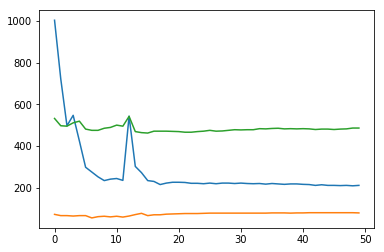

1


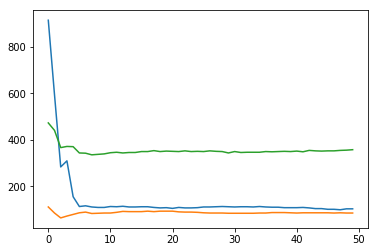

2


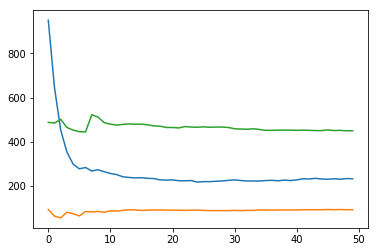

3


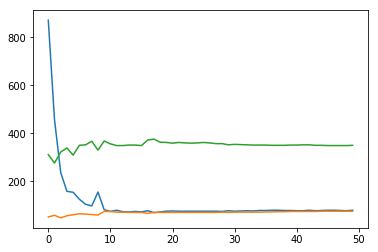

4


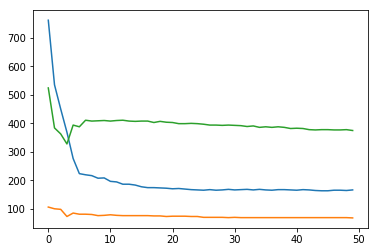

5


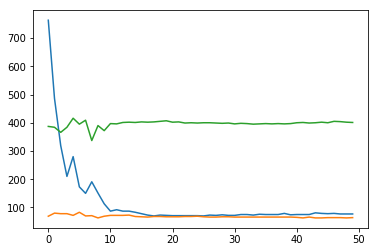

6


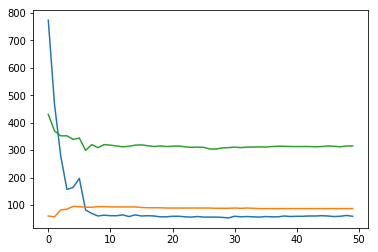

7


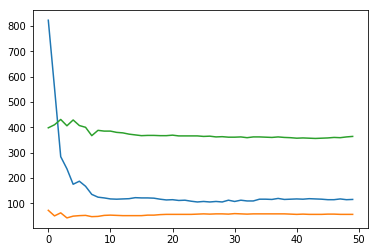

8


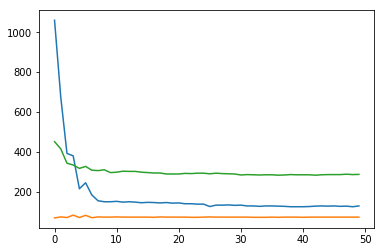

9


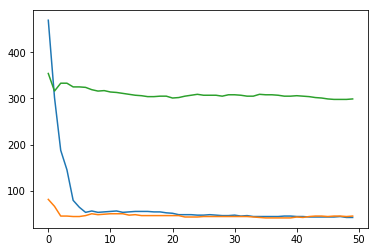

10


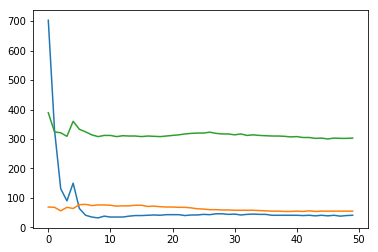

11


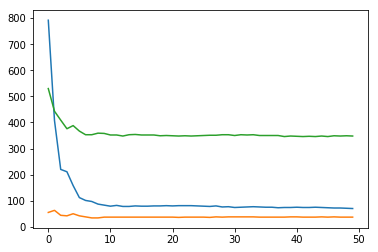

12


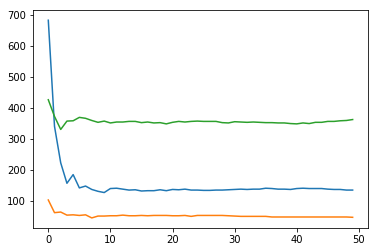

13


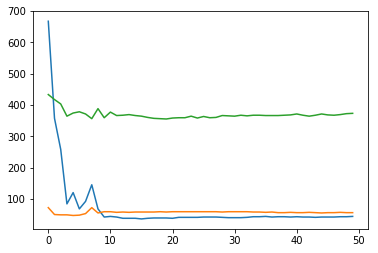

14


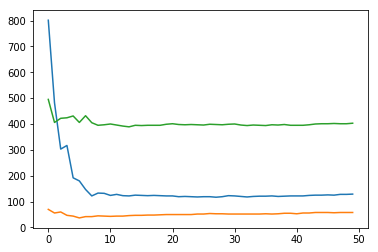

15


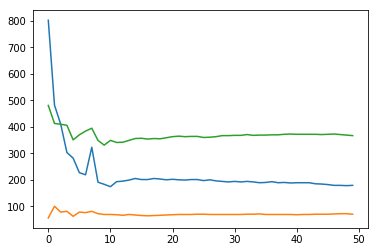

16


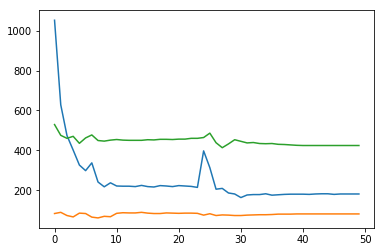

17


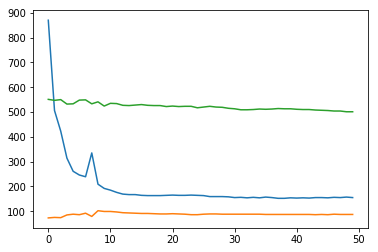

18


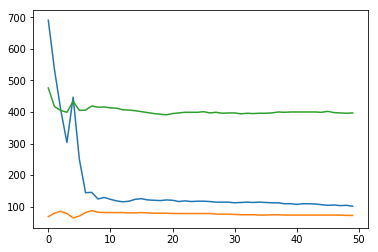

19


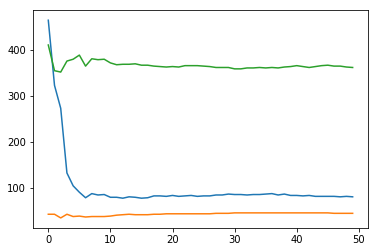

20


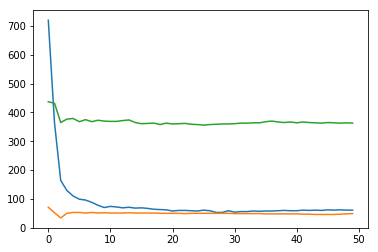

21


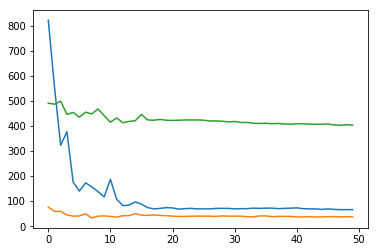

22


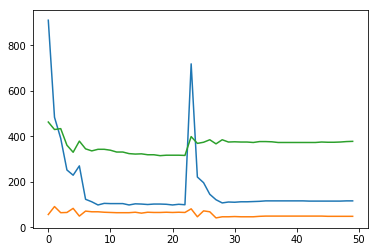

23


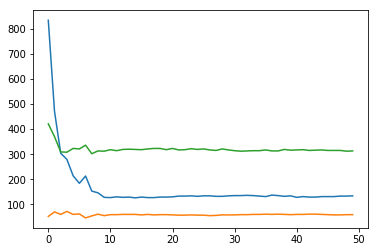

24


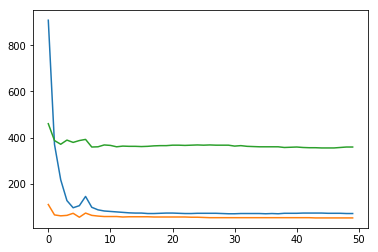

25


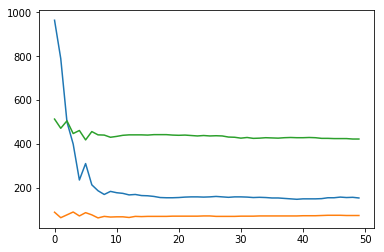

26


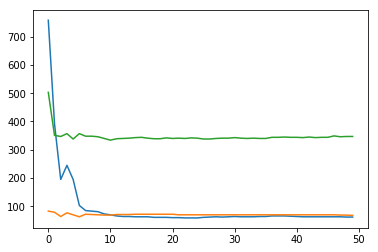

27


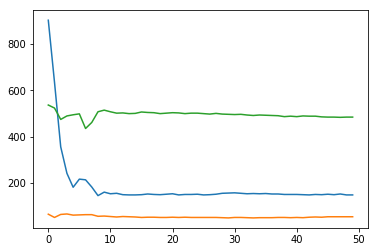

28


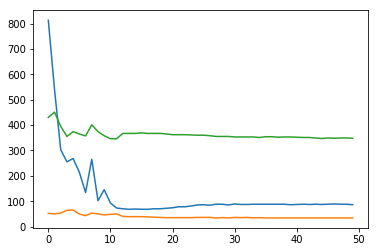

29


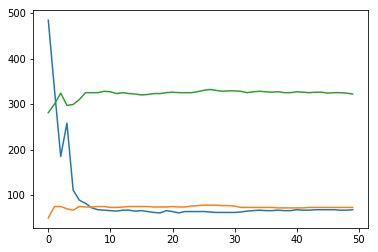

30


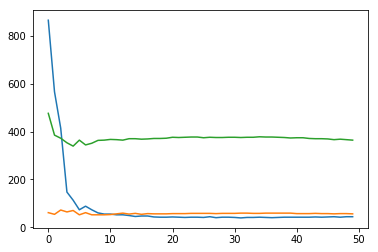

31


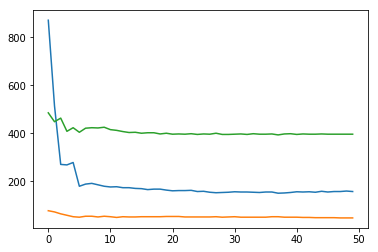

32


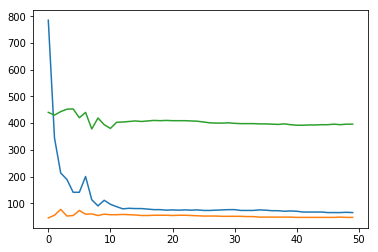

33


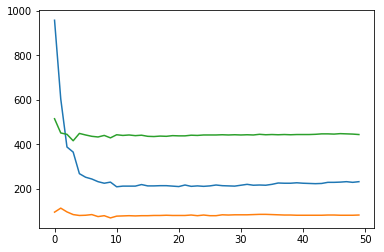

34


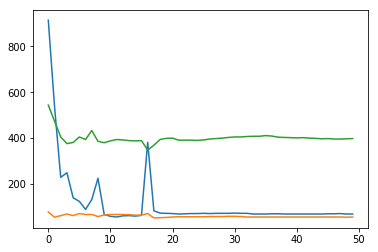

35


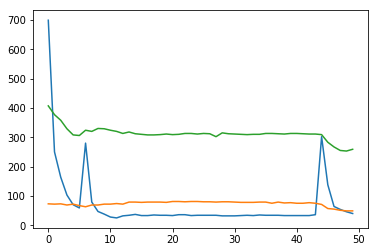

36


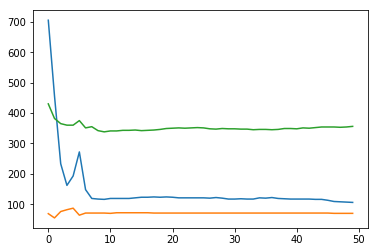

37


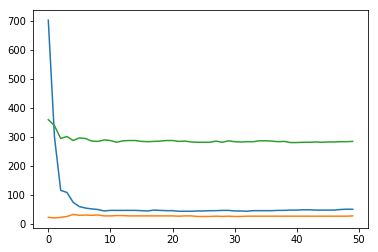

38


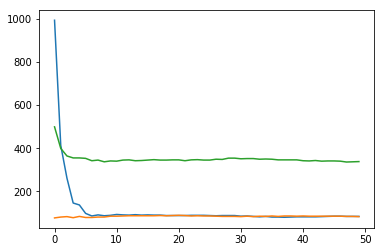

39


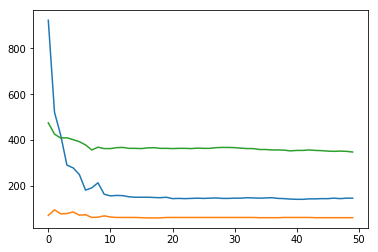

40


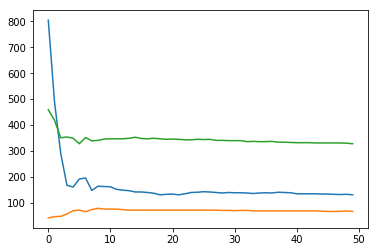

41


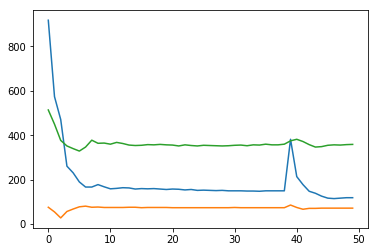

42


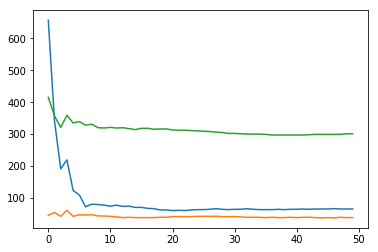

43


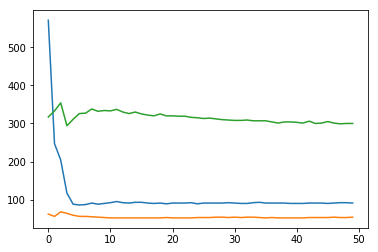

44


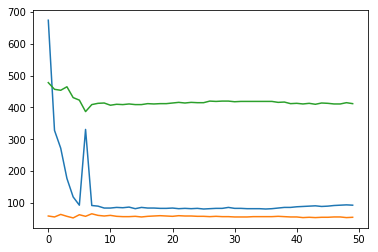

45


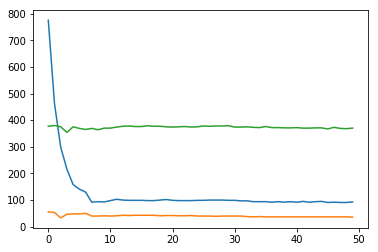

46


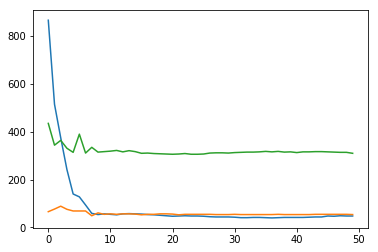

47


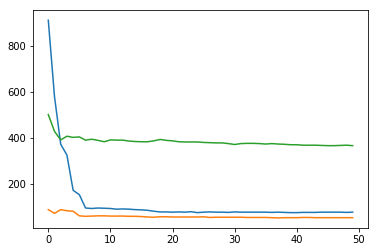

48


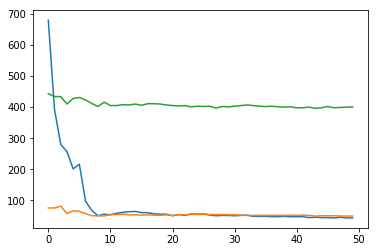

49


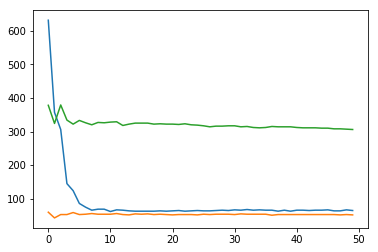

In [7]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


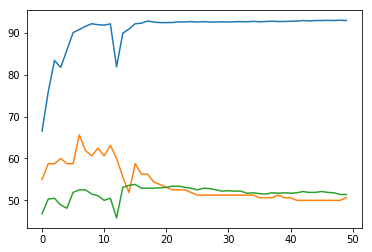

1


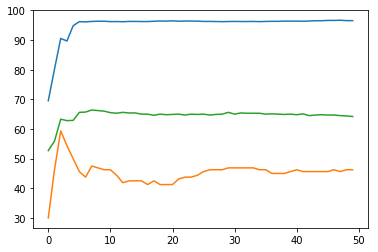

2


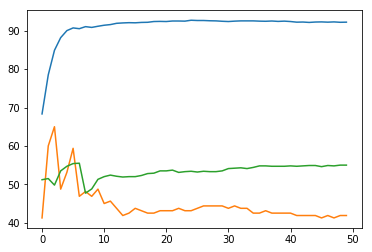

3


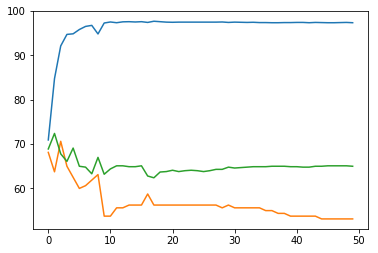

4


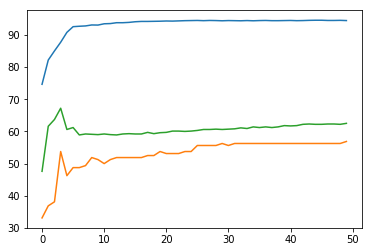

5


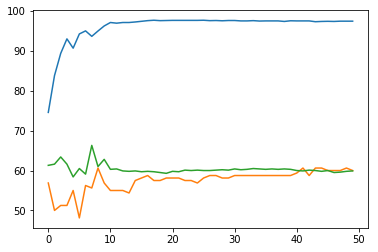

6


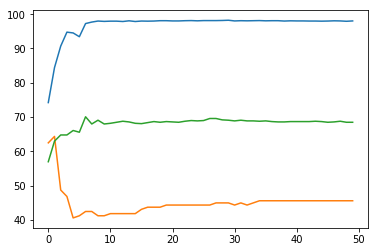

7


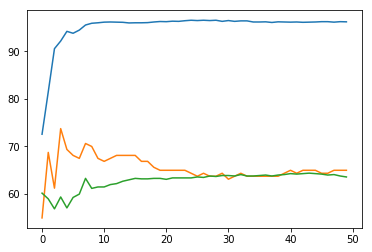

8


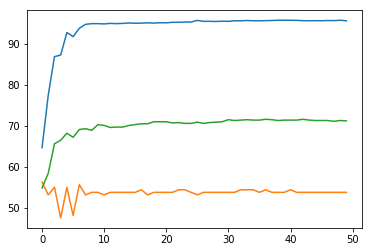

9


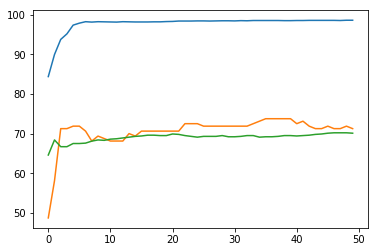

10


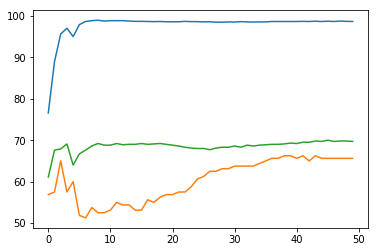

11


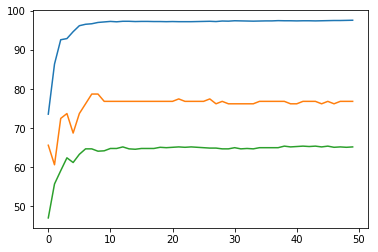

12


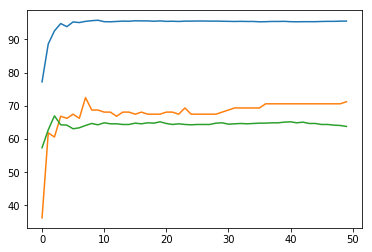

13


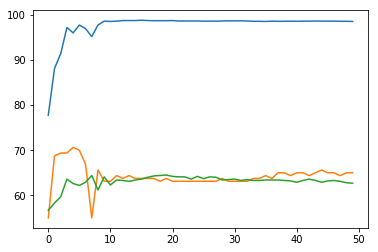

14


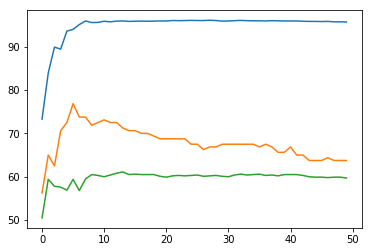

15


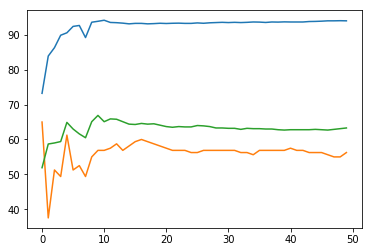

16


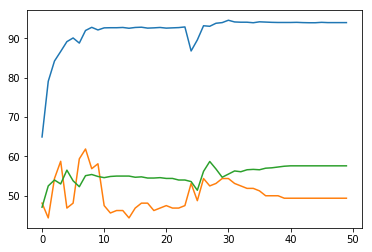

17


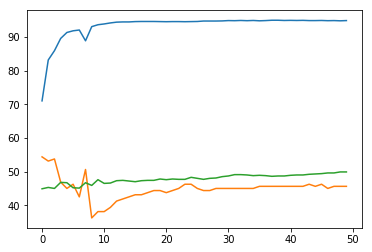

18


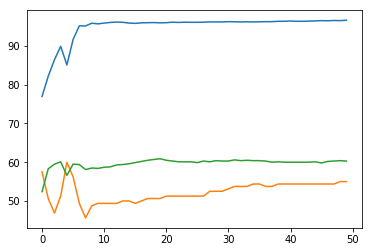

19


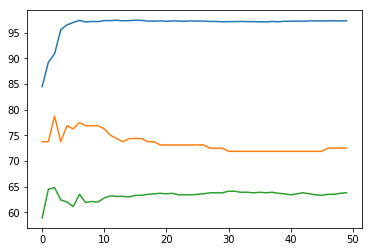

20


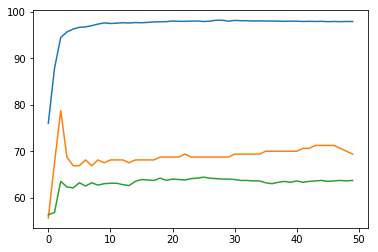

21


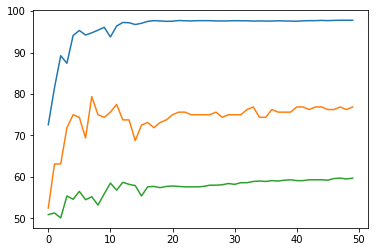

22


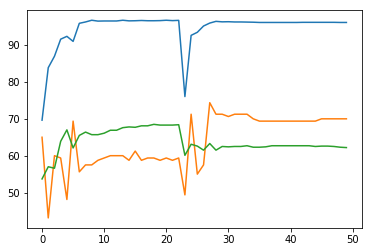

23


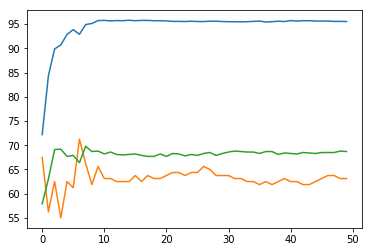

24


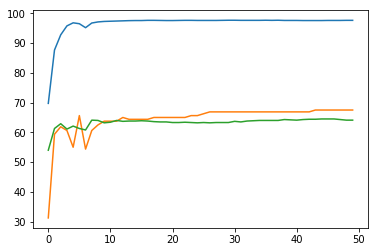

25


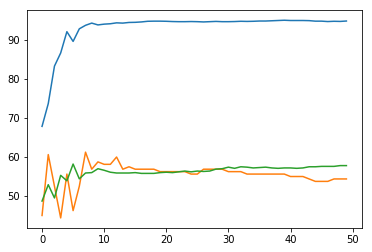

26


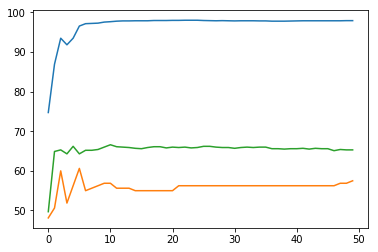

27


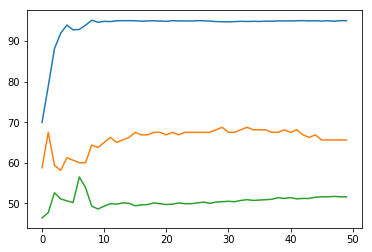

28


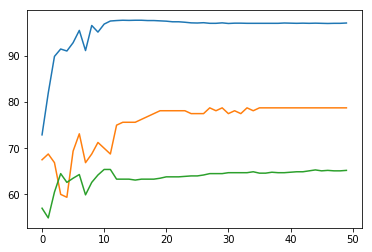

29


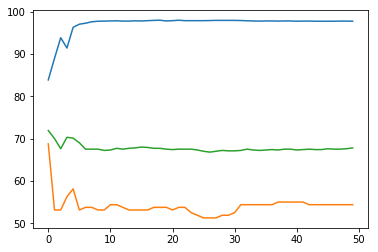

30


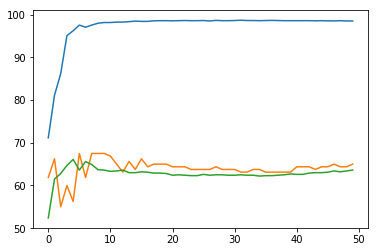

31


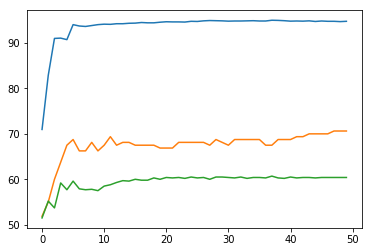

32


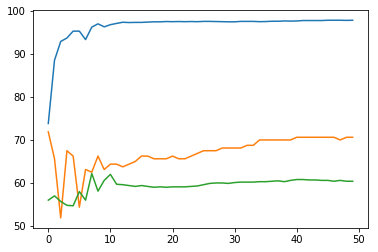

33


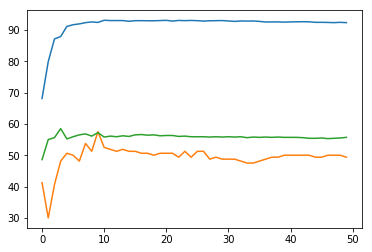

34


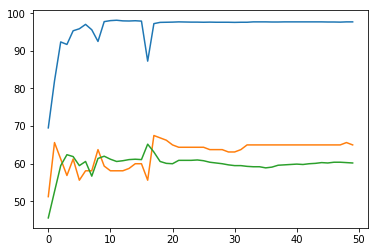

35


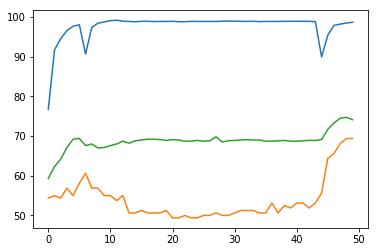

36


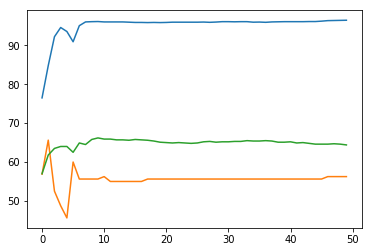

37


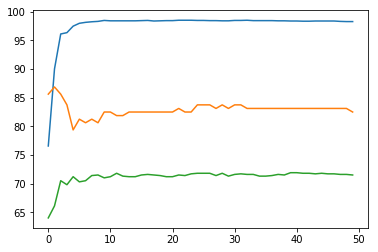

38


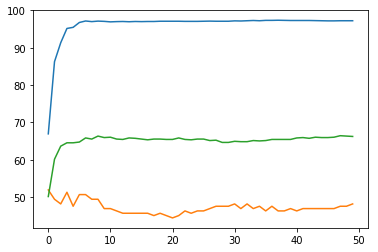

39


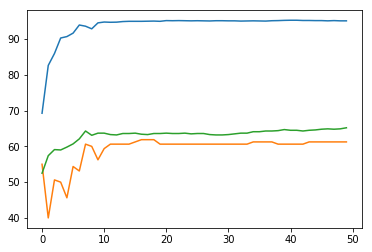

40


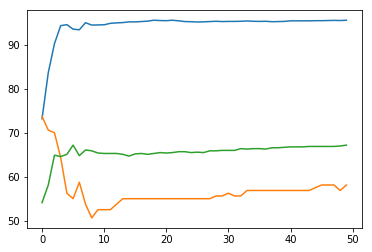

41


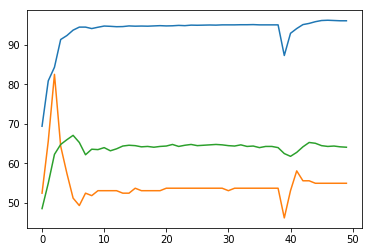

42


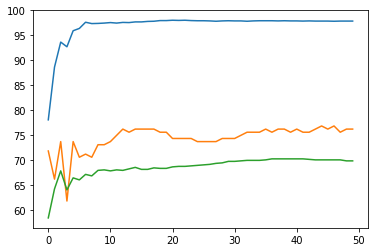

43


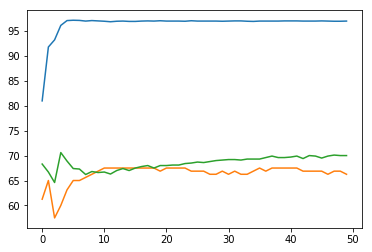

44


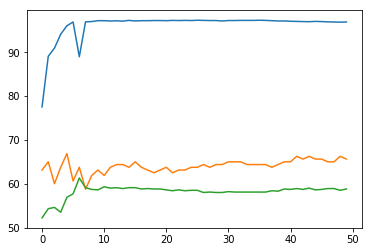

45


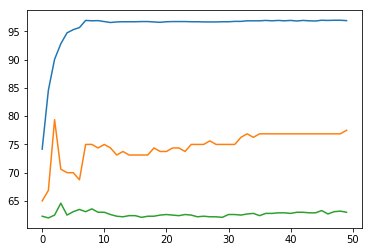

46


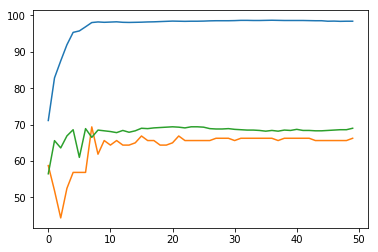

47


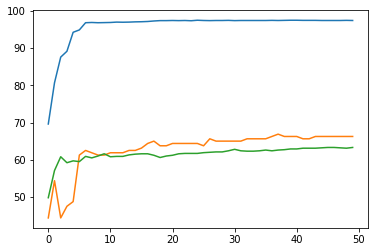

48


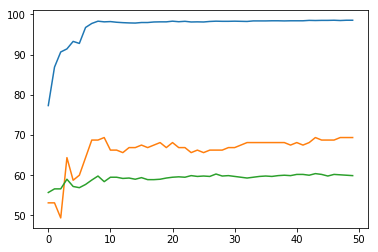

49


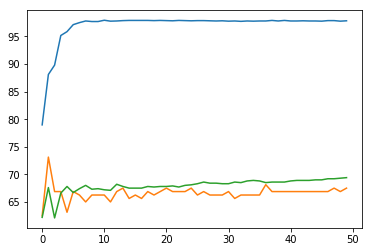

In [8]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

In [1]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(50))
print(stddev_train_errors.shape)

plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
plt.errorbar(epoch, mean_test_errors, stddev_test_errors)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

NameError: name 'Ntrain' is not defined